In [7]:
# we'll use LLM from Ollama
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

llm.invoke("Hey How are you?")

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-08T17:41:37.800844Z', 'done': True, 'done_reason': 'stop', 'total_duration': 19398688250, 'load_duration': 1355329667, 'prompt_eval_count': 30, 'prompt_eval_duration': 14375329125, 'eval_count': 47, 'eval_duration': 3664818250, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b9eb2-d3a0-75e3-ac0c-31dbc73fe7d6-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 30, 'output_tokens': 47, 'total_tokens': 77})

In [22]:
from langgraph.graph import StateGraph , START, END 
from typing import TypedDict, Annotated 
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver

In [23]:
# we'll need a reducer function to add messages to the list
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [24]:
from langchain_core.prompts import PromptTemplate

def get_response(state: ChatState)->ChatState:
    template = """
                You are a helpful chatbot, which takes user query and history of messages and returns an output.
                <query + history> {messages} </query + history> 
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['messages']
    )

    chain = prompt | llm 

    response = chain.invoke({'messages' : state['messages']})
    return {
        'messages' : [response]
    }

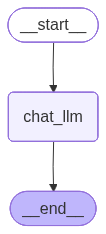

In [25]:
checkpointer = MemorySaver()

# define graph 
graph = StateGraph(ChatState)

# adding node 
graph.add_node('chat_llm', get_response)

# add edge 
graph.add_edge(START, "chat_llm")
graph.add_edge("chat_llm", END)

# compile graph 
chatbot = graph.compile(checkpointer=checkpointer)


# display 
from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())

In [27]:
input_state = {'messages' : [HumanMessage(content="Hey my name is Umesh")]}

config = {'configurable' : {'thread_id' : '1'}}
output_state = chatbot.invoke(input_state, config)

In [28]:
from pprint import pprint 
pprint(output_state)

{'messages': [HumanMessage(content='Hey my name is Umesh', additional_kwargs={}, response_metadata={}, id='684e8e86-2c55-4fef-9d1c-d26c90f6b777'),
              AIMessage(content="Hello Umesh! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-08T18:08:42.331904Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17212865125, 'load_duration': 1190986125, 'prompt_eval_count': 105, 'prompt_eval_duration': 14576337416, 'eval_count': 19, 'eval_duration': 1443135250, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b9ecb-a5ea-7113-93f1-744c2c3f888b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 105, 'output_tokens': 19, 'total_tokens': 124})]}


In [29]:
# for chatbot feels we'll use a while loop until user says to quit 
thread_id = '2'

while True:

    user_input = input("Enter your query : ")

    if user_input.strip().lower() in ['quit', 'exit', 'bye']:
        print("Bye, will talk to you later.")
        break

    print(f"User : {user_input}")

    config = {'configurable' : {'thread_id' : thread_id}}
    response = chatbot.invoke({'messages' : [HumanMessage(content=user_input)]}, config=config)
    print(f"AI : {response['messages'][-1].content}")
    print("-"*79)

User : Hi My name is Umesh
AI : Hello Umesh, it's nice to meet you! What brings you here today? Is there something I can help you with or would you like to chat?
-------------------------------------------------------------------------------
User : What is my name?
AI : Based on the query and history of messages, I can see that the user's name is Umesh. The chatbot has already responded to this by asking if there's something it can help Umesh with or if they'd like to chat.

Here's a possible response:

"Hi Umesh! It's nice to meet you too! Since we've already established your name, I can start fresh and ask: How are you doing today? Is there anything on your mind that you'd like to talk about or any questions you have?"
-------------------------------------------------------------------------------
User : bue
AI : Based on the query and history of messages, I can see that the user's name is Umesh. The chatbot has already responded to this by asking if there's something it can help Ume

In [31]:
# to see what's inside config with different thread_id 
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi My name is Umesh', additional_kwargs={}, response_metadata={}, id='34696d70-092a-41f9-bdf8-1f24593b3583'), AIMessage(content="Hello Umesh, it's nice to meet you! What brings you here today? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-08T18:08:57.623824Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5404827875, 'load_duration': 132358542, 'prompt_eval_count': 102, 'prompt_eval_duration': 2015536625, 'eval_count': 33, 'eval_duration': 3251865083, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b9ecc-0ff2-7682-8bce-0af8c7f8c413-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 102, 'output_tokens': 33, 'total_tokens': 135}), HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='e8d7d442-d81f-4e73-9932-d55c663ff12d'